## 1. Multistock Model

$$ S_t^{(k)} = S_0^{(k)} \cdot exp(\mu^{(k)} t + \sigma^{(k)} B_t^{(k)}) $$

__Assuming $cov(B_{t}^i,B_{s}^j) = min\{t,s\} \cdot \rho_{i,j}$ __

__And: __
$$\sigma_k B_t^{(k)} = \sum_{i}^{k} \sigma_{k,i} W_t^{(i)}$$
$$\sigma^2_k = \sum_{j}^{min\{k,j\}} \sigma^2_{k,j}$$

__Or in matrix form: __
$$\begin{bmatrix}
\sigma_1 B^{(1)}\\
\sigma_2 B^{(2)}\\
\sigma_3 B^{(3)}\\
...\\
\sigma_n B^{(n)}
\end{bmatrix}
{=}
\begin{bmatrix}
\sigma_{11}  & 0 & 0 &...&0\\
\sigma_{21}  & \sigma_{22} & 0 &...&0\\
\sigma_{31} & \sigma_{32 }&\sigma_{33} &... &0\\
...&...&...&...&...\\
\sigma_{n1} &\sigma_{n2} &\sigma_{n3} &...&\sigma_{nn}
\end{bmatrix}
\begin{bmatrix}
W^{(1)}\\
W^{(2)}\\
W^{(3)}\\
...\\
W^{(n)}
\end{bmatrix}
$$

Denote $\{\sigma_{i,j}\}$ as matrix $\Sigma$, $\{\sigma_{i}\}$ as the vector $\sigma$. The last equation can be written as:
$$diag[\sigma] B_t = \Sigma W_t$$

For simplicity, subscript t is ommited in this homework.

Since cov(W) is just $ t I$:
$$ cov(\Sigma W) = \Sigma ( tI) \Sigma^T = t \cdot \Sigma \Sigma^T $$

From historical data, $cov(diag[\sigma] B)$ is directly observable, a.k.a the covariance matrix of stocks log returns.
Scale the covariance matrix by $t$, and decompose it into two matrix: $\Sigma, \Sigma^T$.
Cholesky decomposition is unique, so: 

\begin{eqnarray}
\Sigma &=& CholeskyDecompose(cov(diag[\sigma] B) / t)
\end{eqnarray}

In [1]:
import numpy as np #Handle math objects like vectors and matrixs
import scipy as sp
from scipy.stats import norm # Normal cdf is used
import pandas as pd #Contains data from yahoo
import matplotlib.pyplot as plt # Seeing is believing! --Thrall
from datetime import datetime # Very usefull when you need to operate on date
from datetime import timedelta # Very usefull when you need to operate on date
from yahoo_finance import Share # API from Yahoo to fetch data
%matplotlib inline
float_formatter = lambda x: "%.3f" % x if x >=0 else "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
pd.options.display.float_format = '{:20,.3f}'.format

* Choose the stocks

In [2]:
universe = ['SPY','GOOG','AAPL','AMZN','MSFT','IBM','M','MNST','PNC','ROST','COO']

In [3]:
n = len(universe)

In [14]:
i = datetime.now()
j = i - timedelta(days=252*2)
currentDate = "%s-%s-%s"%(i.year,i.month,i.day-1)
startDate = "%s-%s-%s"%(j.year,j.month,j.day)

* M is the dataframe that stores log returns of all the stocks.

In [16]:
count = 0
for symbol in universe:
    equity = Share(symbol)
    df = pd.DataFrame(equity.get_historical(startDate,currentDate))
    df.index = df.Date
    df.drop('Date',1,inplace = True)
    df.sort_index(inplace = True) # ,ascending = False
    df['Adj_Close'] = pd.to_numeric(df['Adj_Close'])
    label = symbol#+'_logReturn'
    df[label] = np.log(1+df.Adj_Close.diff(1)/df.Adj_Close)
#     df.fillna(0,inplace = True)
    df.dropna(inplace = True)
    
    if count==0:
        M = df[[label]].copy()
    else:
        M = M.join(df[[label]])
    
    count += 1


* Solve the covariance matrix of the stocks ($C=cov(diag[\sigma] B)/t$)

In [17]:
dt = 1/252
set1 = [x for x in universe if x != 'SPY']
covMat = np.cov(M[set1].values.T)
# covMat = np.cov(M.values.T)
C = covMat/dt
print(C)

[[0.035 0.019 0.031 0.027 0.013 0.008 0.018 0.014 0.013 0.013]
 [0.019 0.049 0.022 0.022 0.013 0.007 0.012 0.017 0.012 0.015]
 [0.031 0.022 0.073 0.028 0.013 -0.00 0.030 0.015 0.009 0.014]
 [0.027 0.022 0.028 0.044 0.017 0.011 0.019 0.019 0.014 0.014]
 [0.013 0.013 0.013 0.017 0.034 0.015 0.008 0.019 0.008 0.006]
 [0.008 0.007 -0.00 0.011 0.015 0.152 0.009 0.024 0.030 0.012]
 [0.018 0.012 0.030 0.019 0.008 0.009 0.071 0.006 0.015 0.010]
 [0.014 0.017 0.015 0.019 0.019 0.024 0.006 0.049 0.013 0.008]
 [0.013 0.012 0.009 0.014 0.008 0.030 0.015 0.013 0.041 0.010]
 [0.013 0.015 0.014 0.014 0.006 0.012 0.010 0.008 0.010 0.047]]


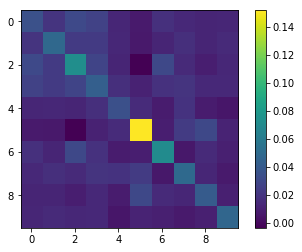

In [19]:
plt.imshow(C)
plt.colorbar() 

In [20]:
dt = 1/252
corrMat = np.corrcoef(M[set1].values.T)
print(corrMat)

[[1.000 0.469 0.603 0.695 0.369 0.105 0.359 0.339 0.331 0.322]
 [0.469 1.000 0.374 0.485 0.325 0.081 0.206 0.348 0.270 0.307]
 [0.603 0.374 1.000 0.494 0.252 -0.04 0.416 0.250 0.168 0.230]
 [0.695 0.485 0.494 1.000 0.446 0.134 0.333 0.419 0.331 0.313]
 [0.369 0.325 0.252 0.446 1.000 0.212 0.162 0.459 0.216 0.141]
 [0.105 0.081 -0.04 0.134 0.212 1.000 0.089 0.272 0.378 0.138]
 [0.359 0.206 0.416 0.333 0.162 0.089 1.000 0.103 0.273 0.174]
 [0.339 0.348 0.250 0.419 0.459 0.272 0.103 1.000 0.289 0.161]
 [0.331 0.270 0.168 0.331 0.216 0.378 0.273 0.289 1.000 0.228]
 [0.322 0.307 0.230 0.313 0.141 0.138 0.174 0.161 0.228 1.000]]


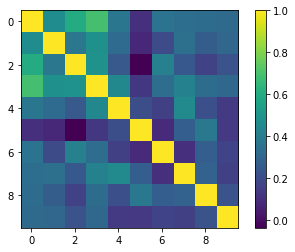

In [21]:
plt.imshow(corrMat)
plt.colorbar()

* Perform Cholesky on C to get $\Sigma$

__$\Sigma = CholeskyDecompose(C)$__

In [22]:
Sigma = np.linalg.cholesky(C)
print(Sigma)

[[0.187 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.104 0.195 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.163 0.028 0.214 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.145 0.037 0.015 0.144 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.068 0.032 0.003 0.042 0.164 0.000 0.000 0.000 0.000 0.000]
 [0.041 0.014 -0.05 0.036 0.065 0.376 0.000 0.000 0.000 0.000]
 [0.096 0.011 0.066 0.022 -0.00 0.020 0.238 0.000 0.000 0.000]
 [0.075 0.047 0.006 0.046 0.062 0.038 -0.02 0.183 0.000 0.000]
 [0.067 0.026 -0.01 0.024 0.010 0.065 0.029 0.016 0.172 0.000]
 [0.070 0.039 0.005 0.018 -0.01 0.022 0.008 -0.00 0.014 0.200]]


* Recover standard deviation of log returns of stocks $\sigma_k$ from formula:

$$\sigma^2_k = \sum_{j}^{min\{k,j\}} \sigma^2_{k,j}$$

In [121]:
sigma = np.sum(Sigma**2,axis = 1)**(0.5)
print(np.linalg.inv(np.diag(sigma**2)))

[[28.523 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 20.443 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 13.648 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 22.984 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 29.212 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 6.595 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 14.081 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 20.377 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 24.463 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 21.054]]


$$ R = diag[\sigma]^{-1}\Sigma $$
$$ d = det(R)^{1/n}$$

In [61]:
R = np.dot(np.linalg.inv(np.diag(sigma)),Sigma)
d = np.linalg.det(R)**(1/n)
print('The diversity is ', d)

The diversity is  0.877432831007


Another way to decompose the covariance matrix is PCA(SVD)

$$C = U \Lambda U^T$$

We will now show that even though $U \Lambda U^T =  \Sigma \Sigma^T$, $U \Lambda^{\frac{1}{2}} \neq \Sigma$

In [25]:
u,s,v = np.linalg.svd(C)

Show eigen values

In [26]:
print(s)

[0.203 0.142 0.061 0.043 0.038 0.029 0.027 0.024 0.019 0.011]


In [27]:
ul = np.dot(u,np.diag(s**0.5))
print(np.dot(ul,ul.T))

[[0.035 0.019 0.031 0.027 0.013 0.008 0.018 0.014 0.013 0.013]
 [0.019 0.049 0.022 0.022 0.013 0.007 0.012 0.017 0.012 0.015]
 [0.031 0.022 0.073 0.028 0.013 -0.00 0.030 0.015 0.009 0.014]
 [0.027 0.022 0.028 0.044 0.017 0.011 0.019 0.019 0.014 0.014]
 [0.013 0.013 0.013 0.017 0.034 0.015 0.008 0.019 0.008 0.006]
 [0.008 0.007 -0.00 0.011 0.015 0.152 0.009 0.024 0.030 0.012]
 [0.018 0.012 0.030 0.019 0.008 0.009 0.071 0.006 0.015 0.010]
 [0.014 0.017 0.015 0.019 0.019 0.024 0.006 0.049 0.013 0.008]
 [0.013 0.012 0.009 0.014 0.008 0.030 0.015 0.013 0.041 0.010]
 [0.013 0.015 0.014 0.014 0.006 0.012 0.010 0.008 0.010 0.047]]


* In the cell above we can see $U \Lambda^{\frac{1}{2}} (U\Lambda^{\frac{1}{2}})^T= C$.

* Next we compare $U \Lambda^{\frac{1}{2}}$ and $\Sigma$ :

In [28]:
print(ul)

[[-0.12 0.086 0.018 -0.00 0.023 -0.02 0.022 0.051 -0.03 -0.08]
 [-0.12 0.078 0.076 -0.04 -0.03 -0.10 -0.09 -0.04 0.007 0.001]
 [-0.15 0.167 -0.03 0.046 0.132 0.003 0.022 -0.04 0.030 0.017]
 [-0.14 0.084 0.042 0.005 -0.01 -0.01 0.013 0.086 -0.06 0.058]
 [-0.10 0.022 0.060 0.050 -0.04 0.042 -0.02 0.064 0.101 -0.00]
 [-0.26 -0.29 -0.03 0.007 0.046 -0.00 -0.02 0.004 -0.01 0.001]
 [-0.13 0.096 -0.19 0.011 -0.08 0.025 -0.04 -0.01 -0.01 -0.00]
 [-0.13 0.011 0.104 0.070 -0.06 0.074 0.015 -0.08 -0.04 -0.01]
 [-0.12 -0.02 -0.01 -0.03 -0.07 -0.07 0.120 -0.02 0.035 0.006]
 [-0.09 0.036 0.023 -0.17 0.013 0.078 0.003 -0.01 0.011 0.002]]


In [29]:
print(Sigma)

[[0.187 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.104 0.195 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.163 0.028 0.214 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.145 0.037 0.015 0.144 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.068 0.032 0.003 0.042 0.164 0.000 0.000 0.000 0.000 0.000]
 [0.041 0.014 -0.05 0.036 0.065 0.376 0.000 0.000 0.000 0.000]
 [0.096 0.011 0.066 0.022 -0.00 0.020 0.238 0.000 0.000 0.000]
 [0.075 0.047 0.006 0.046 0.062 0.038 -0.02 0.183 0.000 0.000]
 [0.067 0.026 -0.01 0.024 0.010 0.065 0.029 0.016 0.172 0.000]
 [0.070 0.039 0.005 0.018 -0.01 0.022 0.008 -0.00 0.014 0.200]]


***************

## Trump Factor

* Regressions

__用Y对X做回归，这里做了三种方法：__

(Y和X可以改，这里随便选了几个股做X，SPY做Y，以后估计要换成几个经济数据做X，个股收益做Y）

* PCR 主成分回归
* Cholesky分解回归（不知道有没有这种搞法，也不知道是不是这个名字，看到PCR想起这个，试一试）
* OLS 一般线性回归

In [30]:
X = M[set1].values-M[set1].mean().values

Y = M[['SPY']].values-M[['SPY']].mean().values

1. PCR：
    
    (1) PCA 分解$X$: $X^{T}X = V\Lambda V^{T}$
    
    (2) 此处$U$是幺正矩阵，对$X$进行旋转: $W = XV$
    
    (3) 用Y对旋转后的$X$ 进行回归: $Y|W \sim N(W \gamma_{PCR},\sigma_{PCR})$
    
    (4) 根据Normal Equation: $\gamma_{PCR} = (W^T W)^{-1}W^T Y$
    
    (5) 将4代入3: $Y|W \sim N(XV \gamma_{PCR},\sigma_{PCR}) \rightarrow Y|X \sim N(X(V \gamma_{PCR}),\sigma_{PCR})$
    
    $\implies Y|X \sim N(X\beta_{PCR},\sigma_{PCR}), \\ \beta_{PCR} = (V \gamma_{PCR})$

In [39]:
# PCA on X^T*X
U,S,V = np.linalg.svd(np.dot(X.T,X))

# Choose number of dimension to keep
dimension = 5

W = np.dot(X,V[:,0:dimension])

gamma_pcr = np.dot(np.dot(np.linalg.inv(np.dot(W.T,W)),W.T),Y)
beta_pcr = np.dot(V[:,0:dimension],gamma_pcr)

------------------------------------------------------
2. Cholesky：
    
    (1) Cholesky 分解$X$: $X^{T}X = \Sigma \Sigma^{T}$
    
    (2) 标准化$\Sigma$使得每个行向量长度为1: $\Sigma \Sigma^{T} = R \sigma R^{T}$
    
    (2) 此处$R$对$X$进行线性变换: $Q = XR$
    
    (3) 用Y对旋转后的$X$ 进行回归: $Y|Q \sim N(Q \gamma_{CHL},\sigma_{CHL})$
    
    (4) 根据Normal Equation: $\gamma_{CHL} = (Q^T Q)^{-1}Q^T Y$
    
    (5) 将4代入3: $Y|Q \sim N(XR \gamma_{CHL},\sigma_{CHL}) \rightarrow Y|X \sim N(X(R \gamma_{CHL}),\sigma_{CHL})$
    
    $\implies Y|X \sim N(X\beta_{CHL},\sigma_{CHL}), \\ \beta_{CHL} = (R \gamma_{CHL})$

In [139]:
sigma

array([0.187, 0.221, 0.271, 0.209, 0.185, 0.389, 0.266, 0.222, 0.202, 0.218])

In [138]:
k = np.argsort(sigma)[0:dimension].tolist()

Q = np.dot(X,R[:,k])

gamma_chl = np.dot(np.dot(np.linalg.inv(np.dot(Q.T,Q)),Q.T),Y)
beta_chl = np.dot(R[:,k],gamma_chl)

3. OLS:

    (1) $Y|X \sim N(X \beta_{OLS},\sigma_{OLS})$
    
    (2) 根据Normal Equation: $\beta_{OLS} = (X^T X)^{-1}X^T Y$

In [64]:
beta_ols = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),Y)

计算样本内预测
$\hat{Y}_{\bullet} = X\beta_{\bullet}$

In [140]:
Y_hat_pcr = np.dot(X,beta_pcr)
Y_hat_chl = np.dot(X,beta_chl)
Y_hat_ols = np.dot(X,beta_ols)

In [141]:
table = pd.DataFrame({'Y_hat_pcr':Y_hat_pcr.squeeze(),
                      'Y_hat_chl':Y_hat_chl.squeeze(),
                      'Y_hat_ols':Y_hat_ols.squeeze(),
                      'Y':Y.squeeze()},index = range(Y.shape[0]))

计算样本内误差

In [142]:
table['error_pcr'] = table['Y']-table['Y_hat_pcr']
table['error_chl'] = table['Y']-table['Y_hat_chl']
table['error_ols'] = table['Y']-table['Y_hat_ols']

图图图图图图图图

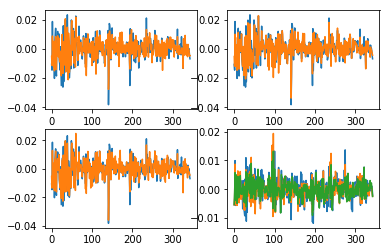

In [143]:
plt.subplot(221)
plt.plot(table[['Y','Y_hat_pcr']])
plt.subplot(222)
plt.plot(table[['Y','Y_hat_chl']])
plt.subplot(223)
plt.plot(table[['Y','Y_hat_ols']])
plt.subplot(224)
plt.plot(table[['error_pcr','error_chl','error_ols']])

In [144]:
table.head()

,Y,Y_hat_chl,Y_hat_ols,Y_hat_pcr,error_pcr,error_chl,error_ols
0,-0.011,-0.005,-0.005,-0.005,-0.005,-0.005,-0.005
1,-0.015,-0.012,-0.014,-0.011,-0.003,-0.003,-0.001
2,0.019,0.010,0.013,0.009,0.010,0.009,0.006
3,-0.006,-0.004,-0.004,-0.003,-0.003,-0.003,-0.003
4,-0.007,-0.002,-0.003,-0.002,-0.006,-0.005,-0.004


In [145]:
betas = pd.DataFrame({'beta_pcr':beta_pcr.squeeze(),'beta_chl':beta_chl.squeeze(),'beta_ols':beta_ols.squeeze()},index = range(beta_pcr.shape[0]))
(betas)

,beta_chl,beta_ols,beta_pcr
0,0.075,0.036,-0.200
1,0.035,0.073,0.167
2,0.045,0.034,0.060
3,0.144,0.115,0.111
4,0.200,0.143,0.097
5,0.047,0.010,0.061
6,0.038,0.043,0.051
7,0.098,0.228,0.205
8,0.066,0.075,0.066
9,0.062,0.065,0.087


Row vectors in R is on unit sphere:

In [75]:
print(np.sum(R**2,axis = 1))

[1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000]


Varify V is a unitary matrix:
$$V V^T = I$$
$$V^T = V^H$$

In [76]:
print(np.dot(V,V.T))

[[1.000 -0.00 0.000 0.000 0.000 0.000 0.000 0.000 -0.00 -0.00]
 [-0.00 1.000 0.000 0.000 0.000 0.000 0.000 0.000 -0.00 0.000]
 [0.000 0.000 1.000 -0.00 0.000 0.000 -0.00 -0.00 0.000 -0.00]
 [0.000 0.000 -0.00 1.000 0.000 -0.00 -0.00 0.000 0.000 -0.00]
 [0.000 0.000 0.000 0.000 1.000 0.000 -0.00 0.000 -0.00 0.000]
 [0.000 0.000 0.000 -0.00 0.000 1.000 0.000 0.000 -0.00 0.000]
 [0.000 0.000 -0.00 -0.00 -0.00 0.000 1.000 -0.00 0.000 -0.00]
 [0.000 0.000 -0.00 0.000 0.000 0.000 -0.00 1.000 0.000 -0.00]
 [-0.00 -0.00 0.000 0.000 -0.00 -0.00 0.000 0.000 1.000 -0.00]
 [-0.00 0.000 -0.00 -0.00 0.000 0.000 -0.00 -0.00 -0.00 1.000]]


In [91]:
print(np.dot(V,np.linalg.inv(V)))

[[1.000 -0.00 -0.00 0.000 -0.00 -0.00 0.000 0.000 0.000 0.000]
 [0.000 1.000 -0.00 -0.00 -0.00 -0.00 -0.00 -0.00 0.000 0.000]
 [-0.00 0.000 1.000 0.000 -0.00 -0.00 -0.00 0.000 0.000 -0.00]
 [0.000 -0.00 0.000 1.000 0.000 -0.00 0.000 -0.00 -0.00 0.000]
 [0.000 0.000 0.000 0.000 1.000 -0.00 0.000 0.000 -0.00 -0.00]
 [-0.00 -0.00 -0.00 0.000 -0.00 1.000 0.000 0.000 0.000 0.000]
 [-0.00 -0.00 0.000 0.000 0.000 -0.00 1.000 0.000 0.000 0.000]
 [-0.00 -0.00 -0.00 0.000 0.000 0.000 0.000 1.000 0.000 -0.00]
 [0.000 -0.00 0.000 -0.00 0.000 -0.00 0.000 0.000 1.000 0.000]
 [0.000 -0.00 -0.00 -0.00 -0.00 0.000 0.000 0.000 0.000 1.000]]


Define a function to compute $R^2$

In [83]:
def score(y,yh):
    y = np.array(y).squeeze()
    yh = np.array(yh).squeeze()
    error = y-yh
    result = 1-(np.cov(error)/np.cov(y))
    return(result)

In [148]:
print('R square for PCR is: ',score(Y,Y_hat_pcr))
print('R square for CHL is: ',score(Y,Y_hat_chl))
print('R square for OLS is: ',score(Y,Y_hat_ols))

R square for PCR is:  0.743994414699
R square for CHL is:  0.807494276256
R square for OLS is:  0.857704276994


In [152]:
print(V)

[[-0.27 -0.27 -0.32 -0.31 -0.22 -0.57 -0.29 -0.28 -0.26 -0.21]
 [0.227 0.208 0.444 0.223 0.058 -0.76 0.254 0.028 -0.05 0.096]
 [0.072 0.308 -0.13 0.171 0.245 -0.13 -0.77 0.424 -0.04 0.094]
 [-0.00 -0.19 0.225 0.025 0.242 0.036 0.053 0.338 -0.14 -0.85]
 [0.118 -0.14 0.681 -0.06 -0.21 0.238 -0.42 -0.31 -0.35 0.069]
 [-0.10 -0.58 0.015 -0.04 0.245 -0.03 0.146 0.437 -0.41 0.458]
 [0.135 -0.57 0.136 0.079 -0.15 -0.14 -0.23 0.093 0.731 0.018]
 [0.330 -0.27 -0.27 0.551 0.411 0.023 -0.05 -0.50 -0.14 -0.06]
 [-0.25 0.054 0.217 -0.44 0.731 -0.04 -0.05 -0.28 0.256 0.082]
 [-0.81 0.009 0.163 0.556 -0.03 0.006 -0.02 -0.06 0.060 0.015]]


In [162]:
np.dot(W,V[0:dimension,:])

array([[0.009, 0.009, 0.015, ..., 0.001, 0.004, 0.010],
       [-0.01, -0.01, -0.03, ..., -0.02, 0.001, 0.016],
       [-0.03, -0.03, -0.02, ..., -0.05, -0.03, 0.019],
       ..., 
       [0.002, 0.001, 0.005, ..., -0.00, 0.002, 0.008],
       [0.001, 0.007, -0.01, ..., 0.004, 0.006, 0.007],
       [-0.00, -0.00, -0.00, ..., -0.00, 0.004, 0.002]])

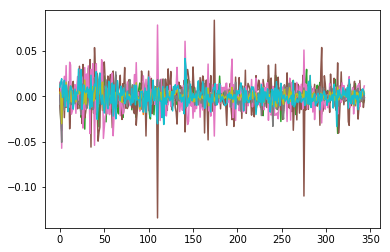

In [168]:
plt.plot(np.dot(W,V[0:dimension,:]))

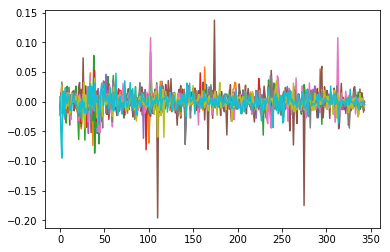

In [164]:
plt.plot(X)